# High-dimensional inference



In [2]:
import arviz as az
import fybdthemes
import jax
import numpy as np
import optax
import sbijax
import seaborn as sns
import tueplots.bundles
import tueplots.axes
%matplotlib inline
import matplotlib.pyplot as plt

from jax import numpy as jnp, random as jr
from jax._src.flatten_util import ravel_pytree
from matplotlib.ticker import AutoLocator, MaxNLocator

from sbijax import NLE
from sbijax.nn import make_affine_maf
from tensorflow_probability.substrates.jax import distributions as tfd

In [3]:
from flax import linen as nn

In [4]:
custom_params = {
    'font.family':'serif', 
    'font.weight':'ultralight', 
    'font.serif':'Computer Modern',
    "axes.labelweight": "light",
    "mathtext.fontset": "stix",
    'text.usetex': True,
}
sns.set_theme(style="ticks", context='paper', rc=custom_params)
plt.rcParams.update(tueplots.bundles.icml2022())
plt.rcParams.update(tueplots.axes.lines(base_width=0.5))

## Example section 3

### Model definition

In [3]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        mean=tfd.Normal(jnp.zeros(2), 1.0),
        scale=tfd.HalfNormal(jnp.ones(1)),
    ))
    return prior


def simulator_fn(seed: jr.PRNGKey, theta: dict[str, jax.Array]):
    p = tfd.Normal(jnp.zeros_like(theta["mean"]), 1.0)
    y = theta["mean"] + theta["scale"] * p.sample(seed=seed)
    return y

### Algorithm definition

In [4]:
n_dim_data = 2
n_layers, hidden_sizes = 5, (64, 64)
neural_network = make_affine_maf(n_dim_data, n_layers, hidden_sizes)
fns = prior_fn, simulator_fn
model = SNL(fns, neural_network)

### Training and inference

In [24]:
obs = jnp.array([-1.0, 1.0])
data, _ = model.simulate_data(jr.PRNGKey(0), n_simulations=10_000)
params, losses = model.fit(
    jr.PRNGKey(1), data=data
)
# inference_results, diagnostics = model.sample_posterior(
#     jr.PRNGKey(2), params, obs
# )

 13%|██████████████████▍                                                                                                                        | 133/1000 [00:38<04:08,  3.49it/s]


In [5]:
print(inference_results)

Inference data with groups:
	> posterior
	> observed_data


In [6]:
print(inference_results.posterior)

<xarray.Dataset> Size: 56kB
Dimensions:    (chain: 4, draw: 1000, mean_dim: 2, scale_dim: 1)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * mean_dim   (mean_dim) int64 16B 0 1
  * scale_dim  (scale_dim) int64 8B 0
Data variables:
    mean       (chain, draw, mean_dim) float32 32kB -1.058 0.9226 ... 0.8237
    scale      (chain, draw, scale_dim) float32 16kB 0.1377 1.043 ... 0.2873
Attributes:
    created_at:     2024-06-04T07:30:29.581578
    arviz_version:  0.17.1


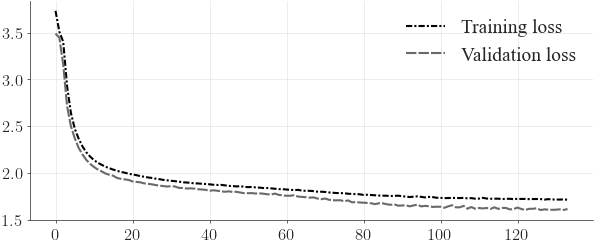

In [45]:
def plot_losses(losses):    
    max_dim = 2
    colors = sns.blend_palette([ "#636363", "#b26679"], n_colors=max_dim)    
    _, ax = plt.subplots(figsize=(6, 2.5), sharey=False, sharex=False)

    with az.style.context(["arviz-white"], after_reset=True):
        plt.rcParams["font.family"] = "Times New Roman"
        plt.plot(losses[:, 0], label="Training loss", color="black", linestyle=(0, (3, 1, 1, 1)))
        plt.plot(losses[:, 1], label="Validation loss", color="dimgrey", linestyle=(0, (5, 1)))
        ax.spines[['right', 'top']].set_visible(False)
        ax.spines.left.set_linewidth(.5)
        ax.spines.bottom.set_linewidth(.5)
        ax.yaxis.set_major_locator(AutoLocator())
        ax.title.set_fontsize(15)
        ax.yaxis.set_tick_params(labelsize='large')
        ax.xaxis.set_tick_params(labelsize='large')
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(width=0.5, length=2)
        ax.grid(which='major', axis='both', alpha=0.5)
        ax.legend()
    plt.tight_layout()
    plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/bivariate_model-loss-plot.pdf")
    plt.show()
    
plot_losses(losses)

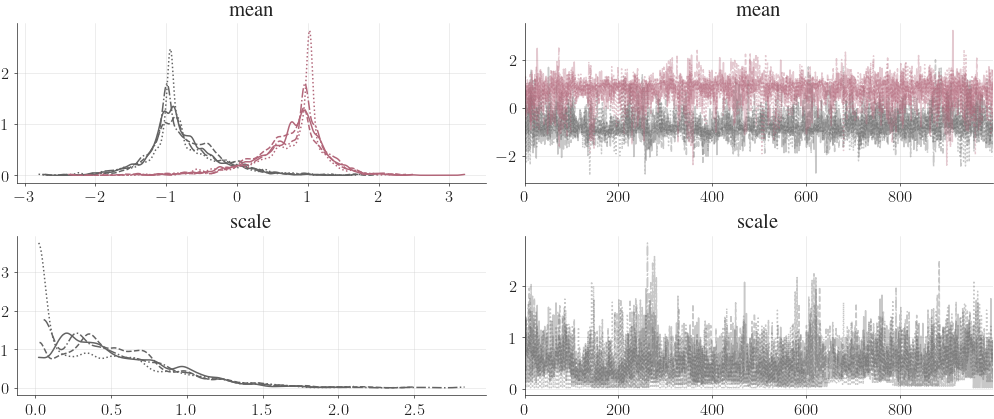

In [14]:
def plot(inference_results):
    var_sizes = inference_results.posterior.sizes
    max_dim = np.max([v for k, v in dict(var_sizes).items() if k not in ["chain", "draw"]])
    colors = sns.blend_palette([ "#636363", "#b26679"], n_colors=max_dim)    
    _, axes = plt.subplots(figsize=(10, 4.25), nrows=2, ncols=2, sharey=False, sharex=False)

    with az.style.context(["arviz-white"], after_reset=True):
        plt.rcParams["font.family"] = "Times New Roman"
        axes = az.plot_trace(
            inference_results, 
            compact_prop={"color": colors},
            axes=axes
        )
        for ax in axes.flatten():
            ax.spines[['right', 'top']].set_visible(False)
            ax.spines.left.set_linewidth(.5)
            ax.spines.bottom.set_linewidth(.5)
            ax.yaxis.set_major_locator(AutoLocator())
            ax.title.set_fontsize(15)
            ax.yaxis.set_tick_params(labelsize='large')
            ax.xaxis.set_tick_params(labelsize='large')
            ax.xaxis.set_tick_params(width=0.5, length=2)
            ax.yaxis.set_tick_params(width=0.5, length=2)
            ax.grid(which='major', axis='both', alpha=0.5)
    plt.tight_layout()
    #plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/trace-plot.pdf")
    plt.show()
    
plot(inference_results)

### Model diagnostics

In [18]:
print(diagnostics.rhat)

<xarray.Dataset> Size: 48B
Dimensions:    (mean_dim: 2, scale_dim: 1)
Coordinates:
  * mean_dim   (mean_dim) int64 16B 0 1
  * scale_dim  (scale_dim) int64 8B 0
Data variables:
    mean       (mean_dim) float64 16B 1.004 1.002
    scale      (scale_dim) float64 8B 1.017


In [27]:
def plot_ranks(inference_results):
    colors = sns.cubehelix_palette(start=.5, rot=-.5,n_colors=4, hue=0.5, dark=0.5, as_cmap=False)
    _, axes = plt.subplots(figsize=(10, 4), nrows=1, ncols=3)

    with az.style.context(["arviz-doc", "arviz-viridish"], after_reset=True):
        plt.rcParams["font.family"] = "Times New Roman"
        ax = az.plot_rank(
            inference_results,
            ax=axes, 
            colors=colors, 
        )
        for i, ax in enumerate(axes):
            ax.spines[['right', 'top', 'left']].set_visible(False)
            ax.spines.left.set_linewidth(.5)
            ax.spines.bottom.set_linewidth(.5)
            ax.yaxis.set_major_locator(AutoLocator())
            ax.title.set_fontsize(15)
            if i > 0:
                ax.set_ylabel(None)
            ax.yaxis.set_tick_params(labelsize='large')
            ax.xaxis.set_tick_params(labelsize='large')
            ax.xaxis.set_tick_params(width=0.5, length=2)
            ax.yaxis.set_tick_params(width=0.5, length=2)
            ax.grid(which='major', axis='both', alpha=0.5)
    plt.tight_layout()
    #plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/rank-plot.pdf")
    plt.show()

plot_ranks(inference_results)

NameError: name 'inference_results' is not defined

In [31]:
inference_results.posterior

<xarray.Dataset> Size: 56kB
Dimensions:    (chain: 4, draw: 1000, mean_dim: 2, scale_dim: 1)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * mean_dim   (mean_dim) int64 16B 0 1
  * scale_dim  (scale_dim) int64 8B 0
Data variables:
    mean       (chain, draw, mean_dim) float32 32kB -1.058 0.9226 ... 0.8237
    scale      (chain, draw, scale_dim) float32 16kB 0.1377 1.043 ... 0.2873
Attributes:
    created_at:     2024-06-04T07:30:29.581578
    arviz_version:  0.17.1

In [29]:
def plot_ess(inference_results):
    _, axes = plt.subplots(figsize=(10, 3), nrows=1, ncols=3)

    colors = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=2, hue=0.5, dark=0.5, as_cmap=False)

    with az.style.context(["arviz-doc", "arviz-viridish"], after_reset=True):
        plt.rcParams["font.family"] = "Times New Roman"
        ax = az.plot_ess(
            inference_results,
            ax=axes, 
            color="#CAE0D8",
            extra_kwargs={"color": "#6F839B"},
            kind="evolution"
        )
        for i, ax in enumerate(axes):
            ax.spines[['right', 'top', 'left']].set_visible(False)
            ax.spines.left.set_linewidth(.5)
            ax.spines.bottom.set_linewidth(.5)
            ax.yaxis.set_major_locator(AutoLocator())
            ax.title.set_fontsize(15)
            if i > 0:
                ax.set_ylabel(None)
            if i < 2:
                ax.get_legend().remove()
            else:
                legend = ax.get_legend()
                ax.legend(bbox_to_anchor=(0.95, .7), frameon=False)
            ax.yaxis.set_tick_params(labelsize='large')
            ax.xaxis.set_tick_params(labelsize='large')
            ax.xaxis.set_tick_params(width=0.5, length=2)
            ax.yaxis.set_tick_params(width=0.5, length=2)
            ax.grid(which='major', axis='both', alpha=0.5)
    plt.tight_layout()
    #plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/ess-plot.pdf")
    plt.show()

#plot_ess(inference_results)

In [242]:
def plot_stan_rhat_and_ess(inference_results, path=None):
    rhats = az.rhat(inference_results)
    rhats = np.concatenate([np.array(v) for k, v in rhats.data_vars.items()])
    rhats = np.squeeze(rhats)
    ress = az.ess(inference_results, relative=True)
    ress = np.concatenate([np.array(v) for k, v in ress.data_vars.items()])
    ress = np.squeeze(ress)
    
    _, axes = plt.subplots(figsize=(6, 1.5), ncols=2)
    colors = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=10, hue=0.5, dark=0.5, as_cmap=False)
       
    axes[0].plot(rhats, range(len(rhats)), marker="o", linestyle='None', color="black")
    axes[0].hlines(range(len(rhats)), np.ones(len(rhats)), rhats, color="black")
    axes[0].axvline(1.05, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[0].axvline(1.1, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[0].axvline(1.0, color="black", alpha=0.5)    
    if np.any(rhats < 1.0):
        axes[0].set_xlim(0.95)    
    else:
        axes[0].set_xlim(0.99)
    if np.any(rhats >= 1.3):
        axes[0].axvline(1.3, color="dimgrey", alpha=0.5, linestyle="dashed")
        axes[0].set_xticks([1.0, 1.05, 1.1, 1.3])
    else:
        axes[0].set_xticks([1.0, 1.05, 1.1])
    axes[0].set_yticklabels([])
    axes[0].set_ylabel(rf"$\theta$", fontsize=15)              
    axes[0].set_xlabel(r"Split-$\hat{R}$")      
    
    axes[1].plot(ress, range(len(ress)), marker="o", linestyle='None', color="black")
    axes[1].hlines(range(len(ress)), np.zeros(len(ress)), ress, color="black")
    axes[1].axvline(0.0, color="black", alpha=0.5)
    axes[1].axvline(0.1, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[1].axvline(0.5, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[1].axvline(1.0, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[1].set_xticks([0.0, 0.1, 0.5, 1.0])
    axes[1].set_yticklabels([])
    axes[1].set_xlabel(r"Relative ESS")     
    
    for i, ax in enumerate(axes):
        ax.spines[['right', 'top']].set_visible(False)
        ax.spines.left.set_linewidth(.5)
        ax.spines.bottom.set_linewidth(.5)
        ax.title.set_fontsize(15)
        if i > 0:
            ax.set_ylabel(None)
        ax.yaxis.set_tick_params(labelsize='large')
        ax.xaxis.set_tick_params(labelsize='large')
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(width=0.5, length=2)
        ax.grid(which='major', axis='both', alpha=0.5)
    if path is not None:
        plt.savefig(path)
    plt.show()

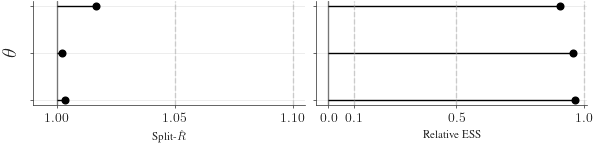

In [245]:
plot_stan_rhat_and_ess(inference_results, "/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/rhat_ress-plot.pdf")

### Sequential inference

In [56]:
n_rounds = 5
data, params = None, {}
for i in range(n_rounds):        
    data, _ = model.simulate_data_and_possibly_append(
        jr.fold_in(jr.PRNGKey(0), i),
        params=params,
        observable=obs,
        data=data,
        sampler="mala",
    )
    params, info = model.fit(jr.fold_in(jr.PRNGKey(1), i), data=data)
inference_results, diagnostics = model.sample_posterior(
    jr.PRNGKey(2), params, obs
)

 12%|██████████████████████▌                                                                                                                                                                     | 120/1000 [00:26<03:17,  4.46it/s]


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

## Examples

In [5]:
def plot_posteriors(obj, save_path=None):
    _, axes = plt.subplots(figsize=(12, 10), nrows=5, ncols=5)
    with az.style.context(["arviz-doc"], after_reset=True):
        for i in range(0, 5):        
            for j in range(0, 5):
                ax = axes[i, j]
                if i < j:
                    ax.axis('off')
                else:
                    ax.hexbin(obj[..., j], obj[..., i], gridsize=50, bins='log', cmap='viridis')            
                ax.spines.left.set_linewidth(.5)
                ax.spines.bottom.set_linewidth(.5)
                ax.spines.right.set_linewidth(.5)
                ax.spines.top.set_linewidth(.5)       
                ax.xaxis.set_major_locator(MaxNLocator(2))
                ax.yaxis.set_major_locator(MaxNLocator(2))
                ax.xaxis.set_tick_params(width=1, length=2, labelsize=25)
                ax.yaxis.set_tick_params(width=1, length=2, labelsize=25)
                if i < 4:                    
                    ax.set_xticklabels([])
                    ax.xaxis.set_tick_params(width=0., length=0)
                if j != 0:                    
                    ax.set_yticklabels([])
                    ax.yaxis.set_tick_params(width=0., length=0)
                ax.grid(which='major', axis='both', alpha=0.5)
        for i in range(5):
            axes[i, i].hist(obj[..., i], color="black")
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


In [6]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(jnp.full(5, -3.0), jnp.full(5, 3.0))
    ), batch_ndims=0)
    return prior


def simulator_fn(seed, theta):
    theta = theta["theta"]
    orig_shape = theta.shape
    if theta.ndim == 2:
        theta = theta[:, None, :]
    us_key, noise_key = jr.split(seed)

    def _unpack_params(ps):
        m0 = ps[..., [0]]
        m1 = ps[..., [1]]
        s0 = ps[..., [2]] ** 2
        s1 = ps[..., [3]] ** 2
        r = jnp.tanh(ps[..., [4]])
        return m0, m1, s0, s1, r

    m0, m1, s0, s1, r = _unpack_params(theta)
    us = tfd.Normal(0.0, 1.0).sample(
        seed=us_key, sample_shape=(theta.shape[0], theta.shape[1], 4, 2)
    )
    xs = jnp.empty_like(us)
    xs = xs.at[:, :, :, 0].set(s0 * us[:, :, :, 0] + m0)
    y = xs.at[:, :, :, 1].set(
        s1 * (r * us[:, :, :, 0] + jnp.sqrt(1.0 - r**2) * us[:, :, :, 1]) + m1
    )
    if len(orig_shape) == 2:
        y = y.reshape((*theta.shape[:1], 8))
    else:
        y = y.reshape((*theta.shape[:2], 8))
    return y

In [12]:
y_observed = jnp.array([[
    -0.9707123,
    -2.9461224,
    -0.4494722,
    -3.4231849,
    -0.13285634,
    -3.364017,
    -0.85367596,
    -2.4271638,
]])

### MCMC

In [53]:
from functools import partial
from jax import scipy as jsp
from sbijax.mcmc import sample_with_nuts, sample_with_slice

In [54]:
def likelihood_fn(theta, y):
    mu = jnp.tile(theta[:2], 4)
    s1, s2 = theta[2] ** 2, theta[3] ** 2
    corr = s1 * s2 * jnp.tanh(theta[4])
    cov = jnp.array([[s1**2, corr], [corr, s2**2]])
    cov = jsp.linalg.block_diag(*[cov for _ in range(4)])
    p = tfd.MultivariateNormalFullCovariance(mu, cov)
    return p.log_prob(y)


def log_density_fn(theta, y):
    prior_lp = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(jnp.full(5, -3.0), jnp.full(5, 3.0))
    )).log_prob(theta)
    likelihood_lp = likelihood_fn(theta, y)
    lp = jnp.sum(prior_lp) + jnp.sum(likelihood_lp)
    return lp

In [55]:
log_density = partial(log_density_fn, y=obs)

def lp(theta):
    return jax.vmap(log_density)(theta)

slice_samples = sample_with_slice(
    jr.PRNGKey(0),
    lp,
    prior_fn().sample,
    n_chains=10, 
    n_samples=10_000, 
    n_warmup=5_000
)

/Users/simon/miniconda3/envs/sbi-dev/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/simon/miniconda3/envs/sbi-dev/lib/python3.9/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/Users/simon/miniconda3/envs/sbi-dev/lib/python3.9

In [56]:
slice_inference_data = sbijax._src.mcmc.util.as_inference_data({"theta": slice_samples.reshape(10, 5000, 5)}, obs)

In [206]:
sns.cubehelix_palette(start=.75, rot=-.5, n_colors=10, hue=0.5, dark=0.5, as_cmap=False)

[[0.7984163628941724, 0.8724455799341356, 0.8792050282657944],
 [0.7520617729419254, 0.8342884483168719, 0.8537813878463909],
 [0.7091127369272029, 0.7942161194379309, 0.8293423334325812],
 [0.6696142579567184, 0.7523687729661137, 0.8050132518744492],
 [0.6334542285581309, 0.7089583341030783, 0.7799631952015313],
 [0.6003734303188428, 0.6642578287850112, 0.7534347039778444],
 [0.5699801441689186, 0.6185889714716917, 0.7247705359582128],
 [0.5417688749339432, 0.5723083763848336, 0.6934365573435132],
 [0.5151425872967144, 0.525792816587703, 0.6590401645076404],
 [0.4919866284217426, 0.4840435270598958, 0.6252652985274559]]

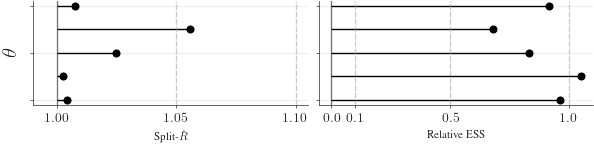

In [222]:
def plot_stan_rhat_and_ess(inference_results):
    rhats = az.rhat(inference_results)    
    rhats = np.squeeze(np.array(rhats.to_dataarray()))
    ress = az.ess(inference_results, relative=True)
    ress = np.squeeze(np.array(ress.to_dataarray()))
    
    _, axes = plt.subplots(figsize=(6, 1.5), ncols=2)
    colors = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=10, hue=0.5, dark=0.5, as_cmap=False)
       
    axes[0].plot(rhats, range(len(rhats)), marker="o", linestyle='None', color="black")
    axes[0].hlines(range(len(rhats)), np.ones(len(rhats)), rhats, color="black")
    axes[0].axvline(1.05, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[0].axvline(1.1, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[0].axvline(1.0, color="black", alpha=0.5)    
    if np.any(rhats < 1.0):
        axes[0].set_xlim(0.95)    
    else:
        axes[0].set_xlim(0.99)
    if np.any(rhats >= 1.3):
        axes[0].axvline(1.3, color="dimgrey", alpha=0.5, linestyle="dashed")
        axes[0].set_xticks([1.0, 1.05, 1.1, 1.3])
    else:
        axes[0].set_xticks([1.0, 1.05, 1.1])
    axes[0].set_yticklabels([])
    axes[0].set_ylabel(rf"$\theta$", fontsize=15)              
    axes[0].set_xlabel(r"Split-$\hat{R}$")      
    
    axes[1].plot(ress, range(len(ress)), marker="o", linestyle='None', color="black")
    axes[1].hlines(range(len(ress)), np.zeros(len(ress)), ress, color="black")
    axes[1].axvline(0.0, color="black", alpha=0.5)
    axes[1].axvline(0.1, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[1].axvline(0.5, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[1].axvline(1.0, color="darkgrey", alpha=0.5, linestyle="dashed")
    axes[1].set_xticks([0.0, 0.1, 0.5, 1.0])
    axes[1].set_yticklabels([])
    axes[1].set_xlabel(r"Relative ESS")     
    
    for i, ax in enumerate(axes):
        ax.spines[['right', 'top']].set_visible(False)
        ax.spines.left.set_linewidth(.5)
        ax.spines.bottom.set_linewidth(.5)
        ax.title.set_fontsize(15)
        if i > 0:
            ax.set_ylabel(None)
        ax.yaxis.set_tick_params(labelsize='large')
        ax.xaxis.set_tick_params(labelsize='large')
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(width=0.5, length=2)
        ax.grid(which='major', axis='both', alpha=0.5)
    plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/slcp-slice_rhat_ess.pdf")
    plt.show()

plot_stan_rhat_and_ess(slice_inference_data)

<xarray.Dataset> Size: 80B
Dimensions:    (theta_dim: 5)
Coordinates:
  * theta_dim  (theta_dim) int64 40B 0 1 2 3 4
Data variables:
    theta      (theta_dim) float64 40B 1.004 1.002 1.025 1.056 1.008

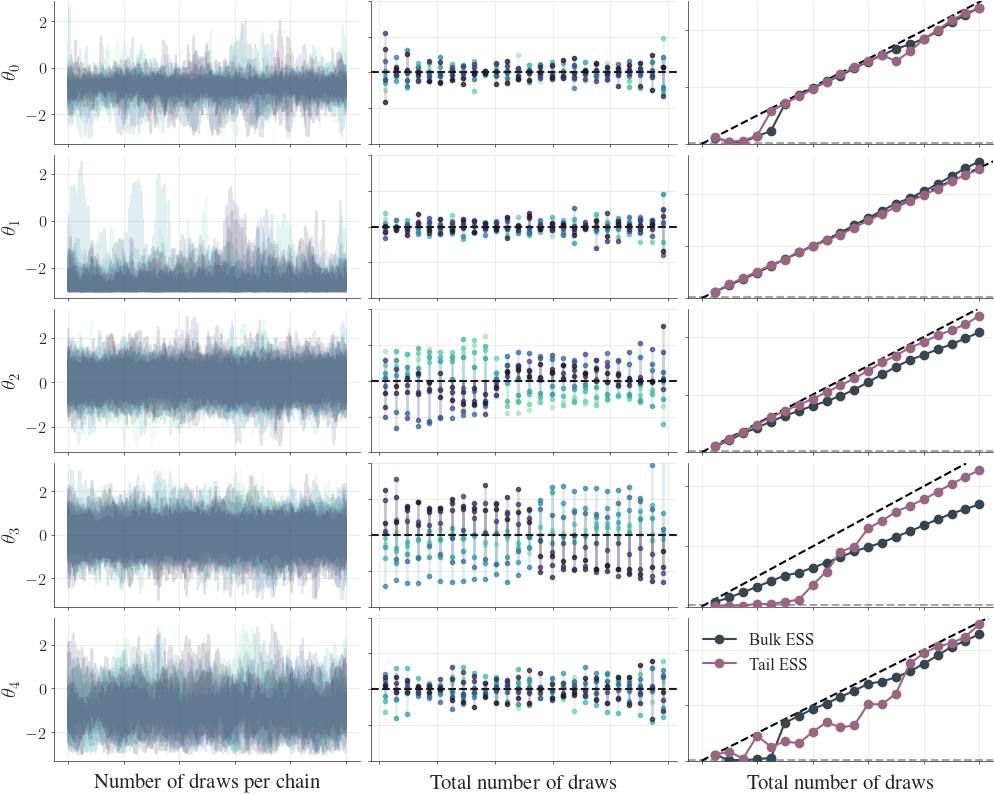

In [232]:
def plot_ess_and_trace(inference_results):
    _, axes = plt.subplots(figsize=(10, 8), nrows=5, ncols=3)

    with az.style.context(["arviz-doc", "arviz-viridish"], after_reset=True):
        plt.rcParams["font.family"] = "Times New Roman"        
        colors = sns.color_palette("ch:s=-.2,r=.6", as_cmap=False, n_colors=10, desat=.8)
        ax = az.plot_ess(
            inference_results,
            ax=[axes[i, 2] for i in range(5)], 
            color="#36454F",
            extra_kwargs={"color": list(colors[-5])},
            kind="evolution"
        )
        for ax in [axes[i, 2] for i in range(5)]:
            ax.axline((0, 0), slope=1, color="black", ls="--")
        colors = sns.color_palette("mako_r", as_cmap=False, n_colors=10)        
        az.plot_rank(inference_results, ax=[axes[i, 1] for i in range(5)],  kind='vlines', colors=colors, vlines_kwargs={"alpha":0.15}, marker_vlines_kwargs={"linestyle":'None', "marker": "o", "ms":3, "alpha": 0.75})        
        for i in range(5):
            for j in range(10):
                axes[i, 0].plot(slice_samples.reshape(10, 5000, 5)[j, :, i], color=colors[j], alpha=0.15)                
                axes[i, 0].set_ylabel(rf"$\theta_{i}$", fontsize=15)              
                axes[i, 1].set_ylabel(None)
                axes[i, 2].set_ylabel(None)        
        for i, ax in enumerate(axes.flatten()):
            ax.set_title(None)
            ax.spines[['right', 'top']].set_visible(False)            
            ax.spines.left.set_linewidth(.5)
            ax.spines.bottom.set_linewidth(.5)
            ax.yaxis.set_major_locator(AutoLocator())                                    
            ax.set_xlabel(None)
            if i in [13, 14]:
                ax.set_xlabel("Total number of draws", fontsize=15)
            if i == 12:
                ax.set_xlabel("Number of draws per chain", fontsize=15)
            if ax.get_legend() is not None:
                ax.get_legend().remove()            
            #ax.legend(bbox_to_anchor=(0.95, .7), frameon=False)
            ax.yaxis.set_tick_params(labelsize=12)
            ax.xaxis.set_tick_params(labelsize=12)
            ax.xaxis.set_tick_params(width=0.5, length=2)
            ax.yaxis.set_tick_params(width=0.5, length=2)
            ax.grid(which='major', axis='both', alpha=0.5)
            if i != [12,13,14]:                    
                ax.set_xticklabels([])
            if i in [2,5,8,11,14]:
                ax.set_yticklabels([])
            axes[4, 2].legend(["Bulk ESS", "Tail ESS"], fontsize=12)
    plt.tight_layout()
    plt.savefig("/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/slcp-slice-tre-plot.pdf")
    plt.show()
#plot_ess(inference_results)

plot_ess_and_trace(slice_inference_data)

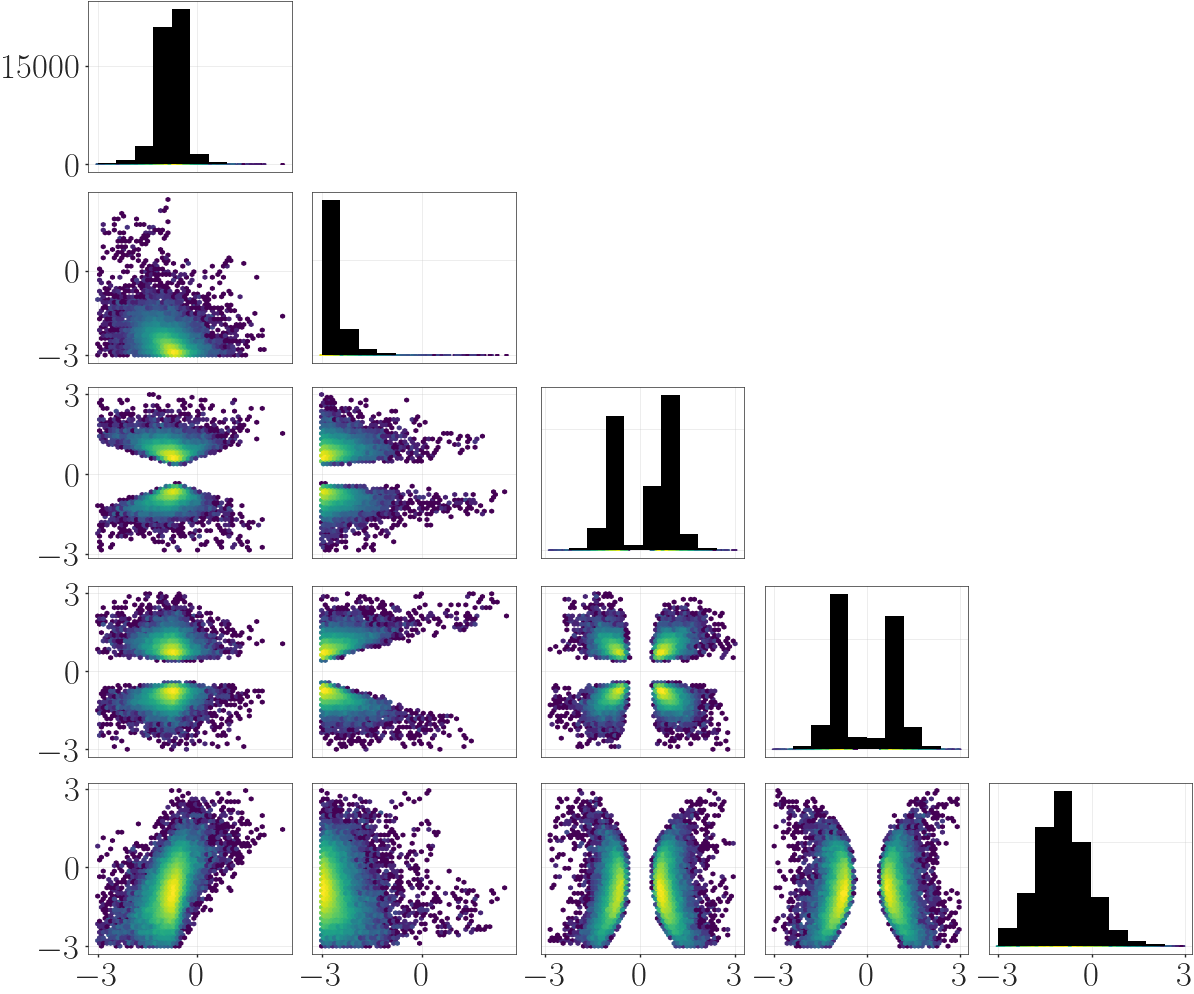

In [11]:
plot_posteriors(
     slice_samples.reshape(-1, 5), 
    "/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/posterior_pair_plot-slice.pdf"
)

### NLE

In [12]:
n_dim_data = obs.shape[-1]
n_layers, hidden_sizes = 5, (64, 64)
neural_network = make_affine_maf(n_dim_data, n_layers, hidden_sizes)
fns = prior_fn, simulator_fn
snl = SNL(fns, neural_network)

In [13]:
data, snl_params = None, {}
for i in range(15):
    data, _ = snl.simulate_data_and_possibly_append(
        jr.fold_in(jr.PRNGKey(1), i),
        params=snl_params,
        observable=obs,
        data=data
    )
    snl_params, info = snl.fit(
        jr.fold_in(jr.PRNGKey(2), i), data=data
    )

 42%|███████████████████████████████████████████████████████▋                                                                            | 422/1000 [02:23<03:16,  2.94it/s]


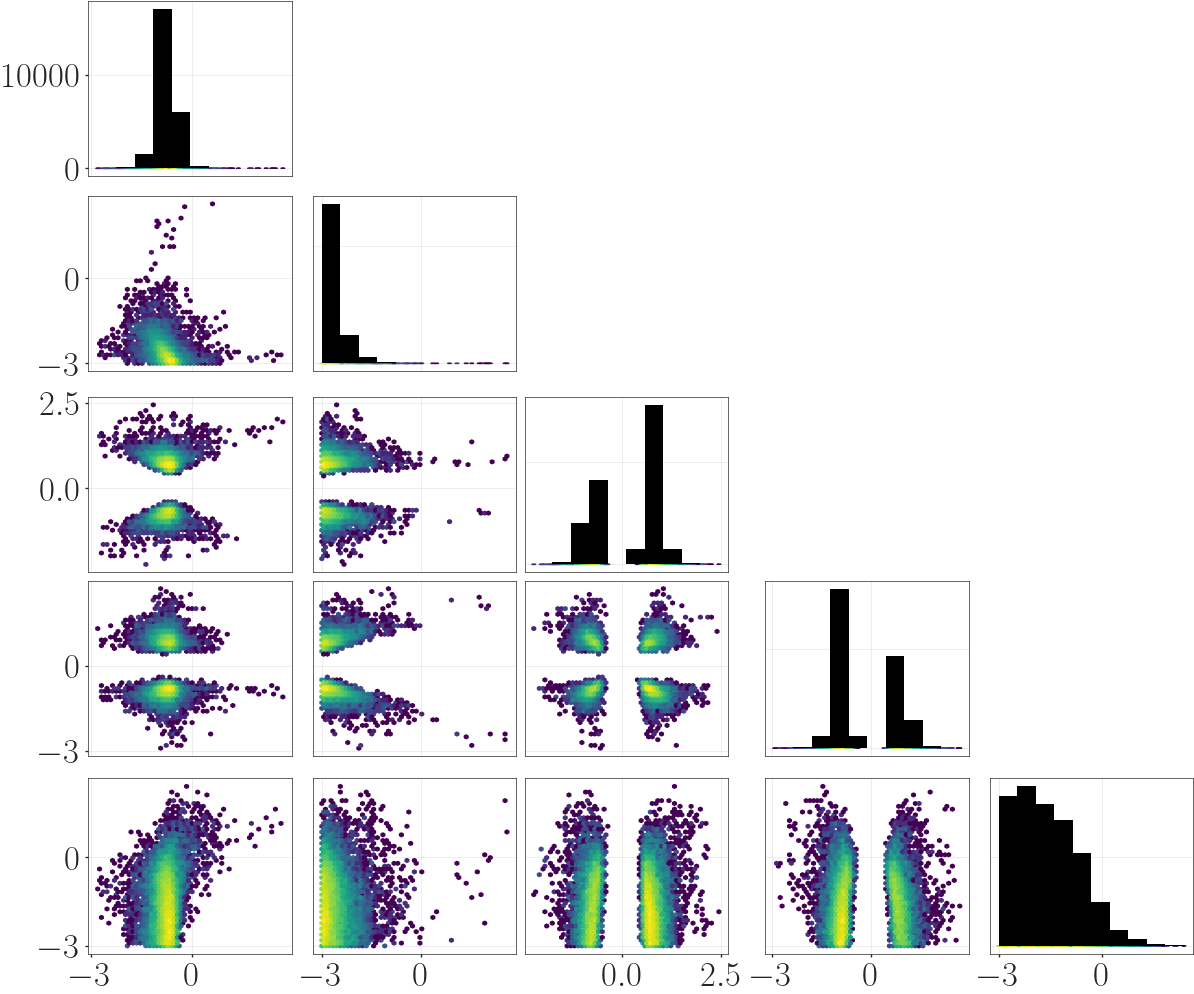

In [18]:
snl_inference_results, diagnostics = snl.sample_posterior(
    jr.PRNGKey(1), snl_params, obs, n_samples=10_000, n_warmup=5000, n_chains=5
)
plot_posteriors(
    sbijax._src.mcmc.util.flatten(snl_inference_results.posterior)["theta"],
    "/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/posterior_pair_plot-snl.pdf"
)

### CMPE

In [53]:
from sbijax import SCMPE
from sbijax.nn import make_consistency_model

In [72]:
n_dim_theta = 5
n_layers, hidden_size = 5, 64
neural_network = make_consistency_model(n_dim_theta, n_layers, hidden_size)
fns = prior_fn, simulator_fn
cmpe = SCMPE(fns, neural_network)

In [76]:
data, cmpe_params = None, {}
for i in range(1):
    data, _ = cmpe.simulate_data_and_possibly_append(
        jr.fold_in(jr.PRNGKey(1), i),
        params=cmpe_params,
        observable=obs,
        data=data, n_simulations=10000
    )
    cmpe_params, info = cmpe.fit(
        jr.fold_in(jr.PRNGKey(2), i), data=data
    )

  2%|███▏                                                                                                                                 | 24/1000 [00:18<12:20,  1.32it/s]


In [77]:
cmpe_inference_results, diagnostics = cmpe.sample_posterior(
    jr.PRNGKey(1), cmpe_params, obs, n_samples=25_000
)

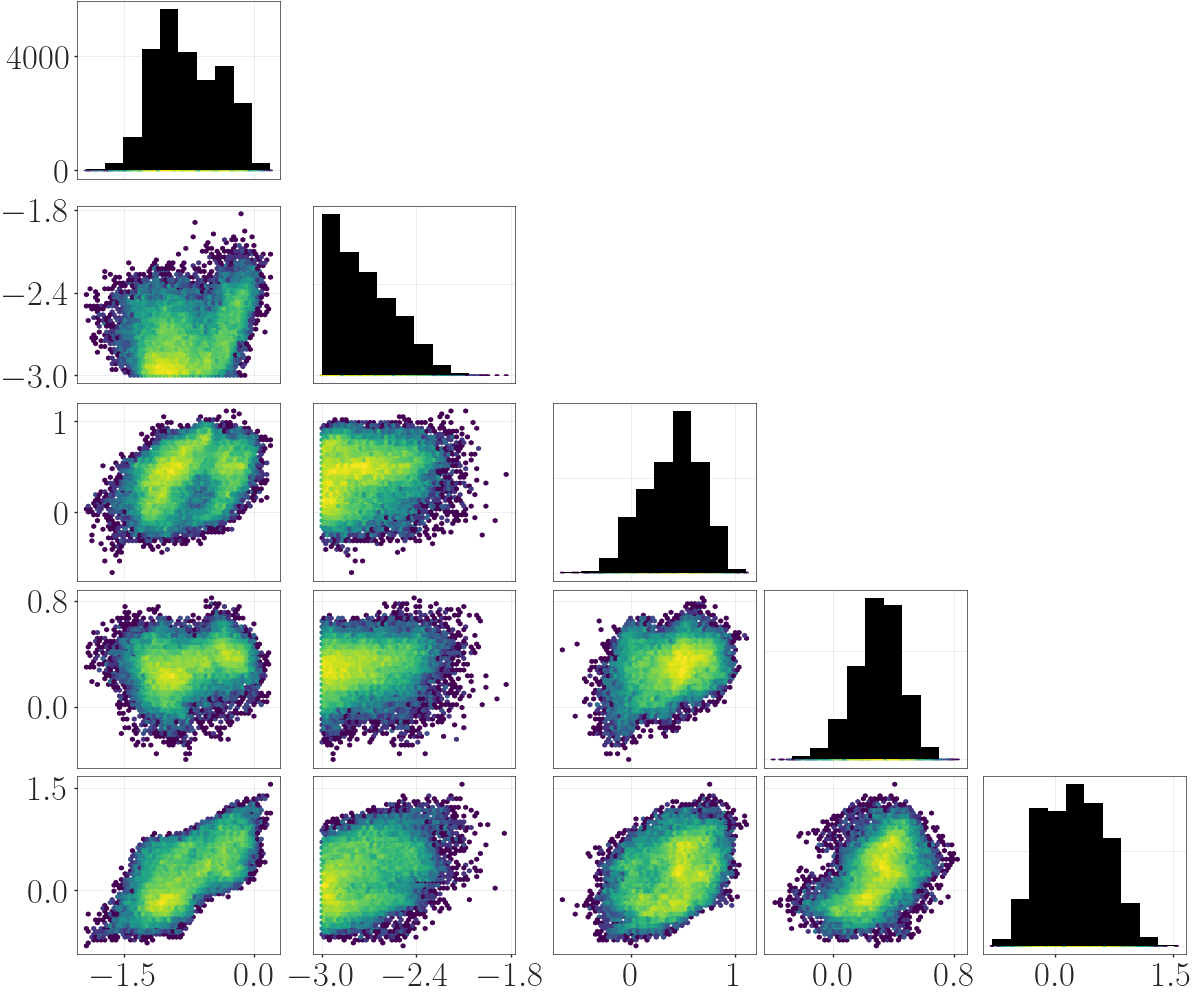

In [75]:
plot_posteriors(
    sbijax._src.mcmc.util.flatten(cmpe_inference_results.posterior)["theta"],
    "/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/posterior_pair_plot-cmpe.pdf"
)

### FMPE

In [6]:
from sbijax import SFMPE
from sbijax.nn import make_ccnf, make_consistency_model

In [7]:
n_dim_theta = 5
n_layers, hidden_size = 5, 128
neural_network = make_ccnf(n_dim_theta, n_layers, hidden_size)
fns = prior_fn, simulator_fn
fmpe = SFMPE(fns, neural_network)

In [11]:
data, fmpe_params = None, {}
for i in range(1):
    data, _ = fmpe.simulate_data_and_possibly_append(
        jr.fold_in(jr.PRNGKey(1), i),
        params=fmpe_params,
        observable=obs,
        data=data,
        n_simulations=20_000,
    )
    fmpe_params, info = fmpe.fit(
        jr.fold_in(jr.PRNGKey(2), i), data=data, optimizer=optax.adam(0.001), n_early_stopping_delta=0.00001, n_early_stopping_patience=30
    )

 12%|███████████████▊                                                                                                                    | 120/1000 [02:13<16:15,  1.11s/it]


In [12]:
fmpe_inference_results, diagnostics = fmpe.sample_posterior(
    jr.PRNGKey(1), fmpe_params, obs, n_samples=25_000
)

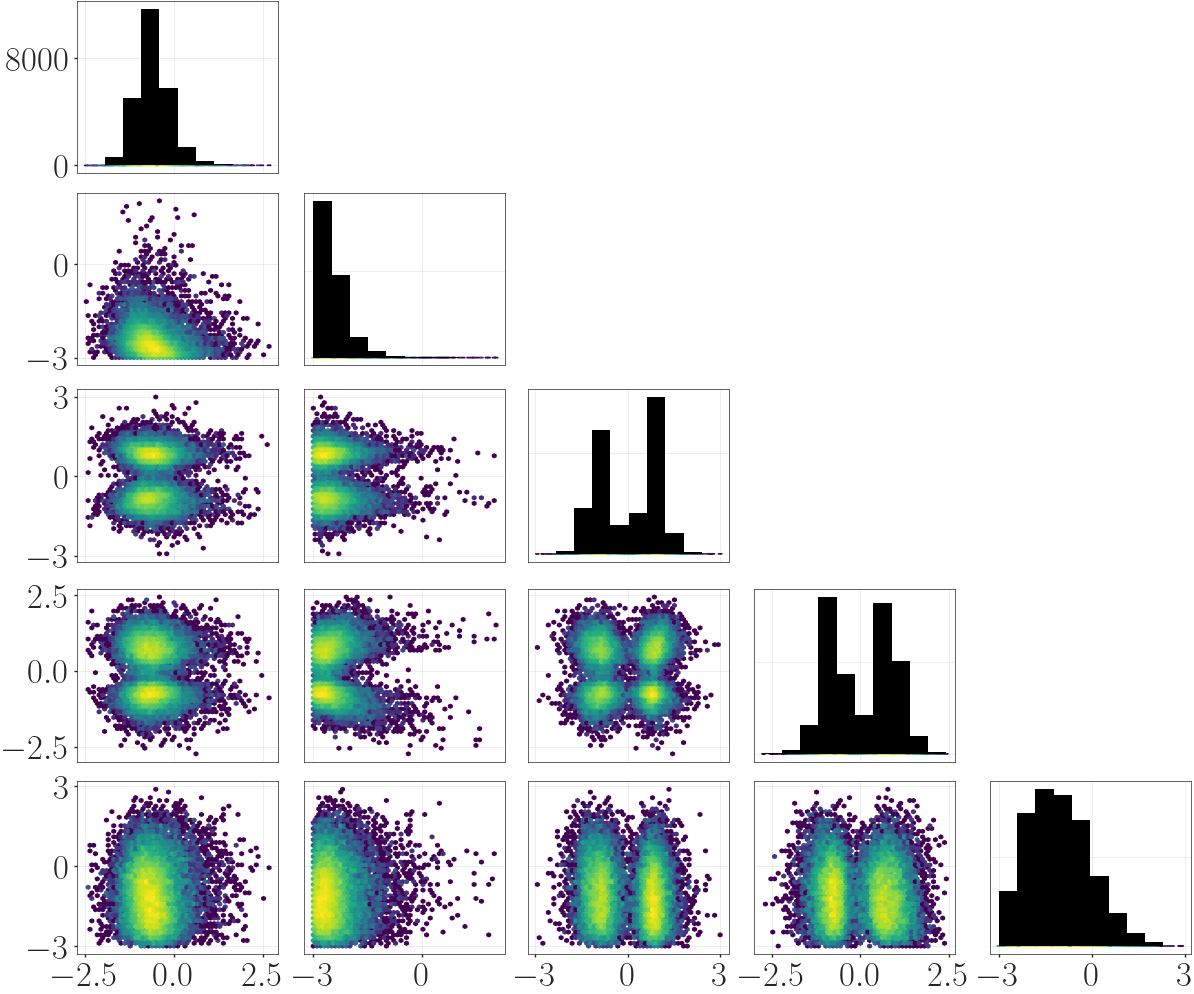

In [13]:
plot_posteriors(
    sbijax._src.mcmc.util.flatten(fmpe_inference_results.posterior)["theta"],
    "/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/posterior_pair_plot-fmpe.pdf"
)

### SMC-ABC

In [8]:
from sbijax import NASS, SMCABC, inference_data_as_dictionary
from sbijax.nn import make_nass_net

In [9]:
fns = prior_fn, simulator_fn
model_nass = NASS(fns, make_nass_net([64, 64, 5], [64, 64, 1]))

data, _ = model_nass.simulate_data(jr.PRNGKey(1), n_simulations=20_000)
params_nass, _ = model_nass.fit(jr.PRNGKey(2), data=data, n_early_stopping_patience=25)

 20%|███████████████████████████                                                                                                               | 196/1000 [02:47<11:25,  1.17it/s]


In [10]:
def distance_fn(y_simulated, y_observed):
    diff = y_simulated - y_observed
    dist = jax.vmap(lambda el: jnp.linalg.norm(el))(diff)
    return dist

def summary_fn(y):
    s = model_nass.summarize(params_nass, y)
    return s

model_smc = SMCABC(fns, summary_fn, distance_fn)

In [13]:
smc_inference_results, _ = model_smc.sample_posterior(
    jr.PRNGKey(3), y_observed, n_rounds=10, n_particles=5_000, eps_step=0.825, ess_min=2_000
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:31<00:00, 39.14s/it]


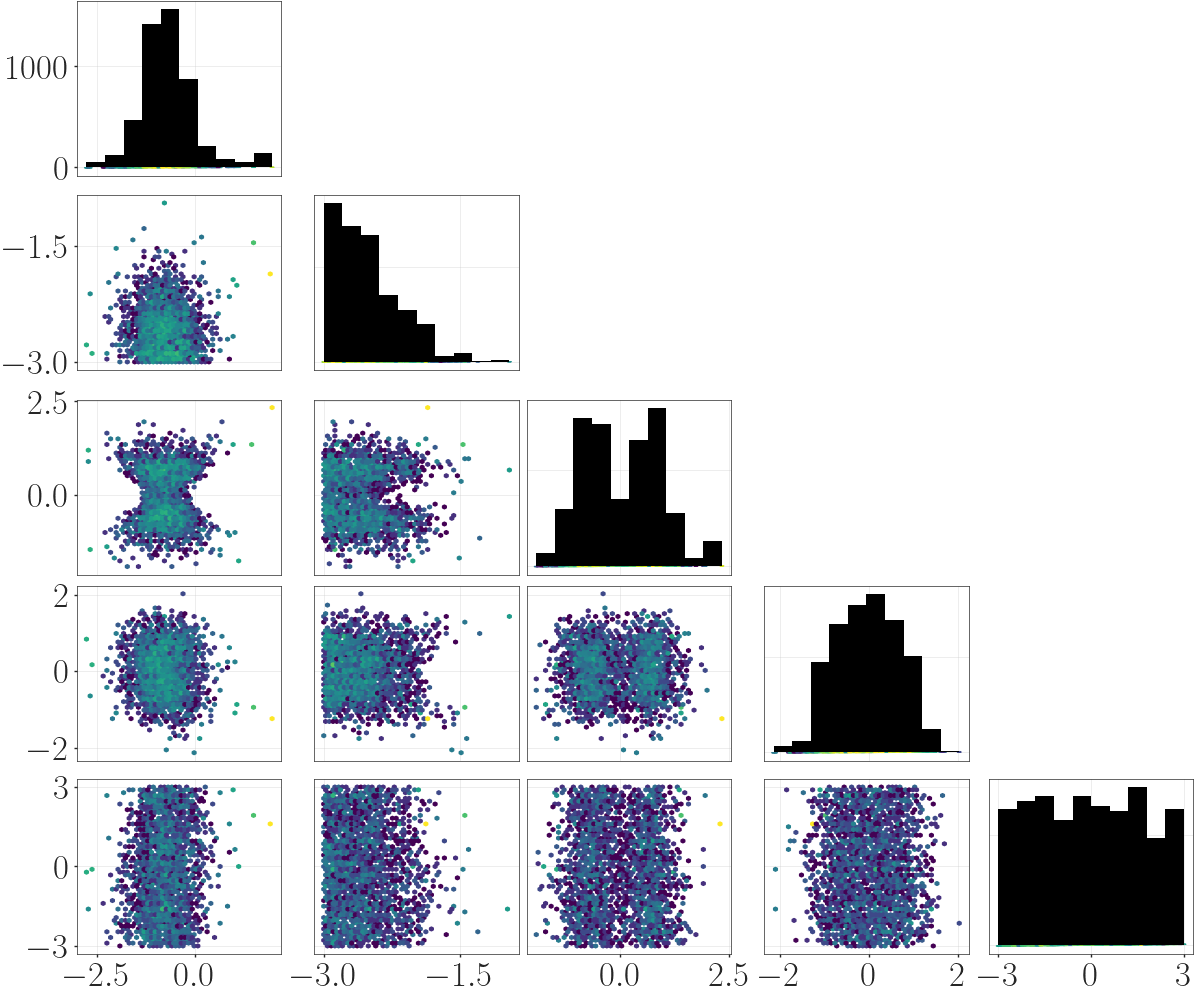

In [14]:
plot_posteriors(
    sbijax._src.mcmc.util.flatten(smc_inference_results.posterior)["theta"],
    "/Users/simon/PROJECTS/2022-bistom/docs/manuscript/sbijax/figures/posterior_pair_plot-smc.pdf"
)